
# Supervised Machine Learning with PySpark

We will be using the Used Cars for Sale Dataset for this tutorial. This dataset has 426,881 rows and 26 columns.

Learning Outcomes:
1. Obtain data using PySpark
2. Clean data using PySpark
3. Data Exploration using PySpark
4. Model Building with PySpark

In [ ]:
! pip install pyspark

In [1]:
#lets import the usual suspects
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#other imports we will be needing in this notebook
import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types
from pyspark.sql.functions import col, isnan, when, count

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor, GBTRegressor, LinearRegression
from pyspark.ml.classification import RandomForestClassifier 
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

warnings.filterwarnings('ignore')

## Connect to the Spark server

We will be using the SparkSession (`spark`) to access our spark cluster..

In [4]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

## Obtaining the Data

The data is uploaded in my Personal drive because of the data size. 

In [2]:
fullpath = 'DataCoSupplyChainDataset.csv'

- It's important to specify the (header = True) so we've the header for dataset elsewhere the spark consider our header as one of the records.

- When we import the data below, the schema (which is similar to a schema in SQL or dtypes in Pandas) has been inferred based on the data.

In [5]:
# read.csv is very similar to the Pandas version
data = spark.read.csv(fullpath,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

In [181]:
data.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

## Data Cleaning

Let's check for null values

In [182]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+------------------------+-----------------------------+-----------------+------------------+---------------+------------------+-----------+-------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+---------------+----------------+-------------+---------------+--------+---------+------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+-------------+---------------+-------------------+-------------------+-------------+------------+-------------+--------------+--------------------------+-------------+
|Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|Delivery Status|Late_delivery_risk|Ca

In [6]:
# these columns have a lot of null values and not necessary so we'll drop them 
drop_cols = ['Product Description','Order Zipcode','Customer Zipcode','Customer Lname', 'Customer Fname',"Benefit per order","Sales per customer","Order Item Cardprod Id","Order Item Product Price","Product Category Id","Order Customer Id", 'Customer Email', 'Customer Password' , 'Product Image' , 'Product_Card_Id']

data = data.drop(*drop_cols)

In [185]:
data.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------+--------------+--------------+----------------+-----------+----------------+--------------+--------------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------------+--------+-------------------+------------------------+-------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+---------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|  Delivery Status|Late_delivery_risk|Category Id| Category Name| Customer City|Customer Country|Customer Id|Customer Segment|Customer State|     Customer Street|Department Id|Department Name|   Latitude|   Longitude|      Market|Order City|Order Country|order date (DateOrders)|Or

### Pre-Processing 
 Let's rename some columns that needs renaming so we can use them easily in the SQl queries. 

In [7]:
data = data.withColumnRenamed("Days for shipping (real)","Days_for_shipping")
data = data.withColumnRenamed("Days for shipment (scheduled)","Days_for_shipment")
data = data.withColumnRenamed("Delivery Status","Delivery_Status")
data = data.withColumnRenamed("Category Id","Category_Id")
data = data.withColumnRenamed("Category Name","Category_Name")
data = data.withColumnRenamed("Category City","Category_City")
data = data.withColumnRenamed("Category Country","Category_Country")
data = data.withColumnRenamed("Customer Id","Customer_Id")
data = data.withColumnRenamed("Customer Segment","Customer_Segment")
data = data.withColumnRenamed("Customer Street","Customer_Street")
data = data.withColumnRenamed("Customer City","Customer_City")
data = data.withColumnRenamed("Customer Country","Customer_Country")
data = data.withColumnRenamed("Customer State","Customer_State")
data = data.withColumnRenamed("Department Id","Department_Id")
data = data.withColumnRenamed("Department Name","Department_Name")
data = data.withColumnRenamed("Order City","Order_City")
data = data.withColumnRenamed("Order Country","Order_Country")
data = data.withColumnRenamed("order date (DateOrders)","Order_date")
data = data.withColumnRenamed("Order Id","Order_Id")
data = data.withColumnRenamed("Order Item Discount","Order_Item_Discount")
data = data.withColumnRenamed("Order Item Discount Rate","Order_tem_Discount_Rate")
data = data.withColumnRenamed("Order Item Id","Order_Item_Id")
data = data.withColumnRenamed("Order Item Profit Ratio","Order_Item_Profit_Ratio")
data = data.withColumnRenamed("Order Item Quantity","Order_Item_Quantity")
data = data.withColumnRenamed("Order Item Total","Order_Item_Total")
data = data.withColumnRenamed("Order Region","Order_Region")
data = data.withColumnRenamed("Order State","Order_State")
data = data.withColumnRenamed("Order Status","Order_Status")
data = data.withColumnRenamed("Order Status","Order_Status")
data = data.withColumnRenamed("Product Name","Product_Name")
data = data.withColumnRenamed("Product Price","Product_Price")
data = data.withColumnRenamed("Product Status","Product_Status")
data = data.withColumnRenamed("shipping date (DateOrders)","Shipping_date")
data = data.withColumnRenamed("Shipping Mode","Shipping_Mode")

In [187]:
data.show()

+--------+-----------------+-----------------+-----------------+------------------+-----------+--------------+--------------+----------------+-----------+----------------+--------------+--------------------+-------------+---------------+-----------+------------+------------+----------+-------------+---------------+--------+-------------------+-----------------------+-------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+---------------+------------+-------------+--------------+---------------+--------------+
|    Type|Days_for_shipping|Days_for_shipment|  Delivery_Status|Late_delivery_risk|Category_Id| Category_Name| Customer_City|Customer_Country|Customer_Id|Customer_Segment|Customer_State|     Customer_Street|Department_Id|Department_Name|   Latitude|   Longitude|      Market|Order_City|Order_Country|     Order_date|Order_Id|Order_Item_Discount|Order_tem_Discount_Rate|Order_Item_Id|O

In [188]:
# let's check again 
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+-----------------+-----------------+---------------+------------------+-----------+-------------+-------------+----------------+-----------+----------------+--------------+---------------+-------------+---------------+--------+---------+------+----------+-------------+----------+--------+-------------------+-----------------------+-------------+-----------------------+-------------------+-----+----------------+----------------------+------------+-----------+------------+---------------+------------+-------------+--------------+-------------+-------------+
|Type|Days_for_shipping|Days_for_shipment|Delivery_Status|Late_delivery_risk|Category_Id|Category_Name|Customer_City|Customer_Country|Customer_Id|Customer_Segment|Customer_State|Customer_Street|Department_Id|Department_Name|Latitude|Longitude|Market|Order_City|Order_Country|Order_date|Order_Id|Order_Item_Discount|Order_tem_Discount_Rate|Order_Item_Id|Order_Item_Profit_Ratio|Order_Item_Quantity|Sales|Order_Item_Total|Order Profit

### EDA

I think the most important features are 
- Order State,Order Region, 
- Order City, Order Country, 
- Latitude, Langitude, 
- Customer Street, Customer City, Customer State.

 
- my target for this analysis will be 'Delivery_Status'

In [8]:
#convert to pandas prior to visualization
df = data.toPandas()

In [9]:
# much more readable!!
df

,Type,Days_for_shipping,Days_for_shipment,Delivery_Status,Late_delivery_risk,Category_Id,Category_Name,Customer_City,Customer_Country,Customer_Id,...,Order Profit Per Order,Order_Region,Order_State,Order_Status,Product Card Id,Product_Name,Product_Price,Product_Status,Shipping_date,Shipping_Mode
0,DEBIT,3,4,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,20755,...,91.250000,Southeast Asia,Java Occidental,COMPLETE,1360,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,19492,...,-249.089996,South Asia,Rajast�n,PENDING,1360,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,19491,...,-247.779999,South Asia,Rajast�n,CLOSED,1360,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,19490,...,22.860001,Oceania,Queensland,COMPLETE,1360,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,19489,...,134.210007,Oceania,Queensland,PENDING_PAYMENT,1360,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,Shipping on time,0,45,Fishing,Brooklyn,EE. UU.,1005,...,40.000000,Eastern Asia,Shangh�i,CLOSED,1004,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,Late delivery,1,45,Fishing,Bakersfield,EE. UU.,9141,...,-613.770019,Eastern Asia,Osaka,COMPLETE,1004,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,Late delivery,1,45,Fishing,Bristol,EE. UU.,291,...,141.110001,Oceania,Australia del Sur,PENDING,1004,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,Advance shipping,0,45,Fishing,Caguas,Puerto Rico,2813,...,186.229996,Oceania,Australia del Sur,PENDING_PAYMENT,1004,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/18/2016 20:18,Standard Class


In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Type                     180519 non-null  object 
 1   Days_for_shipping        180519 non-null  int32  
 2   Days_for_shipment        180519 non-null  int32  
 3   Delivery_Status          180519 non-null  object 
 4   Late_delivery_risk       180519 non-null  int32  
 5   Category_Id              180519 non-null  int32  
 6   Category_Name            180519 non-null  object 
 7   Customer_City            180519 non-null  object 
 8   Customer_Country         180519 non-null  object 
 9   Customer_Id              180519 non-null  int32  
 10  Customer_Segment         180519 non-null  object 
 11  Customer_State           180519 non-null  object 
 12  Customer_Street          180519 non-null  object 
 13  Department_Id            180519 non-null  int32  
 14  Depa

### Descriptive Statistics


In [89]:
df.describe() 

,Days_for_shipping,Days_for_shipment,Late_delivery_risk,Category_Id,Customer_Id,Department_Id,Latitude,Longitude,Order_Id,Order_Item_Discount,Order_tem_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Item_Total,Order Profit Per Order,Product Card Id,Product_Price,Product_Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.0
mean,3.497654,2.931847,0.548291,31.851451,6691.379495,5.443460,29.719955,-84.915675,36221.894903,20.664741,0.101668,90260.000000,0.120647,2.127638,203.772096,183.107609,21.974989,692.509764,141.232550,0.0
std,1.623722,1.374449,0.497664,15.640064,4162.918106,1.629246,9.813646,21.433241,21045.379569,21.800901,0.070415,52111.490959,0.466796,1.453451,132.273077,120.043670,104.433526,336.446807,139.732492,0.0
min,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,-33.937553,-158.025986,1.000000,0.000000,0.000000,1.000000,-2.750000,1.000000,9.990000,7.490000,-4274.979980,19.000000,9.990000,0.0
25%,2.000000,2.000000,0.000000,18.000000,3258.500000,4.000000,18.265432,-98.446312,18057.000000,5.400000,0.040000,45130.500000,0.080000,1.000000,119.980003,104.379997,7.000000,403.000000,50.000000,0.0
50%,3.000000,4.000000,1.000000,29.000000,6457.000000,5.000000,33.144863,-76.847908,36140.000000,14.000000,0.100000,90260.000000,0.270000,1.000000,199.919998,163.990005,31.520000,627.000000,59.990002,0.0
75%,5.000000,4.000000,1.000000,45.000000,9779.000000,7.000000,39.279617,-66.370583,54144.000000,29.990000,0.160000,135389.500000,0.360000,3.000000,299.950012,247.399994,64.800003,1004.000000,199.990005,0.0
max,6.000000,4.000000,1.000000,76.000000,20757.000000,12.000000,48.781933,115.263077,77204.000000,500.000000,0.250000,180519.000000,0.500000,5.000000,1999.989990,1939.989990,911.799988,1363.000000,1999.989990,0.0


From here we can see that we've, 

- 3-Days is the average of actual shipping days of the purchased product in this dataset, the max is 6-days, and the min is same day delivery.

Comparing it to the scheduled;

- 2-Days is the average of scheduled delivery of the purchased product in this dataset, the max is 4-days, and the min is same day delivery

So, the delivery normally takes more than the scheduled days for shipping. 

-----------------------------------------------------------------------------------

- the 'Late_delivery_risk' is a engineered feature it was clear, I think it was created from the 'Delivery_Status' Column. It has binary (int) values. --> it could be converted to object type so we can check the majority of shipping status. 

-----------------------------------------------------------------------------------

- Product_Status of the product stock :If it is 1 not available , 0 the product is availabl, all of them are availabl in this dataset.

-----------------------------------------------------------------------------------

- Latitude is between (-33, 48) and, Longitude is between (-158, 115)


In [10]:
# converting the Late_delivery_risk to object 
df.Late_delivery_risk = df.Late_delivery_risk.astype('object')

In [91]:
df.describe(exclude = 'number') 

,Type,Delivery_Status,Late_delivery_risk,Category_Name,Customer_City,Customer_Country,Customer_Segment,Customer_State,Customer_Street,Department_Name,Market,Order_City,Order_Country,Order_date,Order_Region,Order_State,Order_Status,Product_Name,Shipping_date,Shipping_Mode
count,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519,180519
unique,4,4,2,50,563,2,3,46,7458,11,5,3597,164,65752,23,1089,9,118,63701,4
top,DEBIT,Late delivery,1,Cleats,Caguas,EE. UU.,Consumer,PR,9126 Wishing Expressway,Fan Shop,LATAM,Santo Domingo,Estados Unidos,6/27/2016 13:46,Central America,Inglaterra,COMPLETE,Perfect Fitness Perfect Rip Deck,9/1/2017 0:44,Standard Class
freq,69295,98977,98977,24551,66770,111146,93504,69373,122,66861,51594,2211,24840,5,28341,6722,59491,24515,10,107752


From here we can see that we've, 

- Delivery_Status has four Unique values and 'Late delivery' is the most frequent one.

by default;

- The Late_delivery_risk has 1 as it most frequent class too since ut's mapped to late delivery.  

-----------------------------------------------------------------------------------

- The most Repeated country is the United States (EE. UU.) and, Puerto Rico (PR) is where most of the Customer_State and Caguas is the highest Customer_City which is a city in PR. 

-----------------------------------------------------------------------------------

- For the Order state we have orders from 1089 states in 23 different regions. 


## Data Exploration


### Understanding Categorical Columns , 

since my target is Delivery_Status I'd like to see the my target with the most important columns/features in the dataset.

In [92]:
# Lets check  Order_Status and undertsand the the 9 categories 
df['Order_Status'].value_counts()

COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order_Status, dtype: int64

In [93]:
## Lets check  Customer_Segment and undertsand the the 3 categories 
df['Customer_Segment'].value_counts()

Consumer       93504
Corporate      54789
Home Office    32226
Name: Customer_Segment, dtype: int64

### 1 - Pie Chart

Lets see the percentage of each Customer Segment of customer in the dataset.

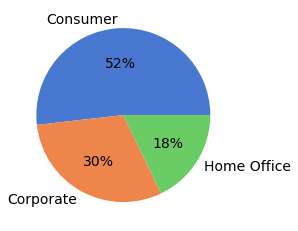

In [94]:
df_cust_seg = df['Customer_Segment'].value_counts().nlargest(3)  
colors = sns.color_palette('muted')

#our pie chart is based on the 3 categories 
plt.pie(df_cust_seg.values, labels=df_cust_seg.index, colors=colors, autopct='%.0f%%', textprops={'fontsize': 14})
plt.show()

- More than half of the the customer segment are Consumers and the other half is between Corporate and Home Office

### 2 - Pie Chart 

Lets see the percentage of top 5 Customer City in the dataset.

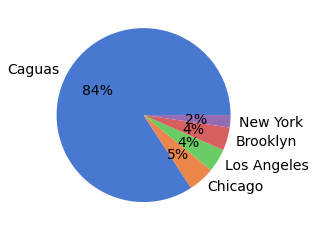

In [95]:
df_cust_city = df['Customer_City'].value_counts().nlargest(5)  
colors = sns.color_palette('muted')

#our pie chart is based on the 5 categories 
plt.pie(df_cust_city.values, labels=df_cust_city.index, colors=colors, autopct='%.0f%%', textprops={'fontsize': 14})
plt.show()

- These are the top cities and we can see that compared to the 'Caguas' it's either they're located in the state of RP or they've popularity there.

### 3 - Histogram 


<AxesSubplot:xlabel='Delivery_Status', ylabel='Count'>

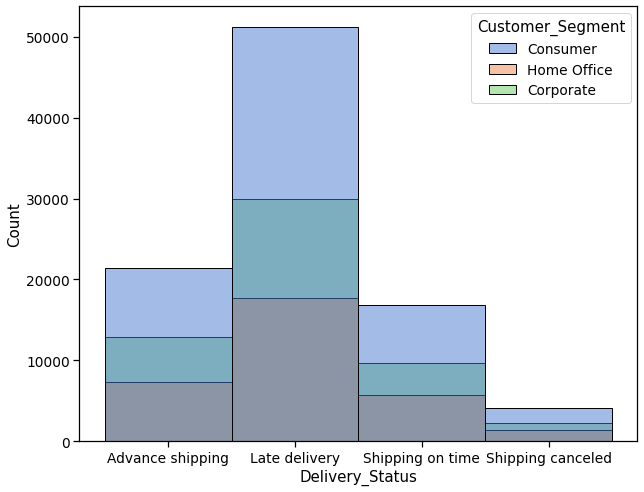

In [24]:
# I'll start with order Customer_Segment and Delivery_Status
df_Region = df[['Delivery_Status' , 'Customer_Segment']]

#we can now create our histogram
plt.figure (figsize=(10,8))
sns.set_context("notebook", font_scale=1.25)
sns.histplot(data=df_Region, x='Delivery_Status', hue='Customer_Segment', binwidth=0.3 , palette='muted')

- We expected the Consumer to be higher for sure because they're in different states and for the Home office to bethe lowest --> the gray like (Orange Behind).

<AxesSubplot:xlabel='Delivery_Status', ylabel='Count'>

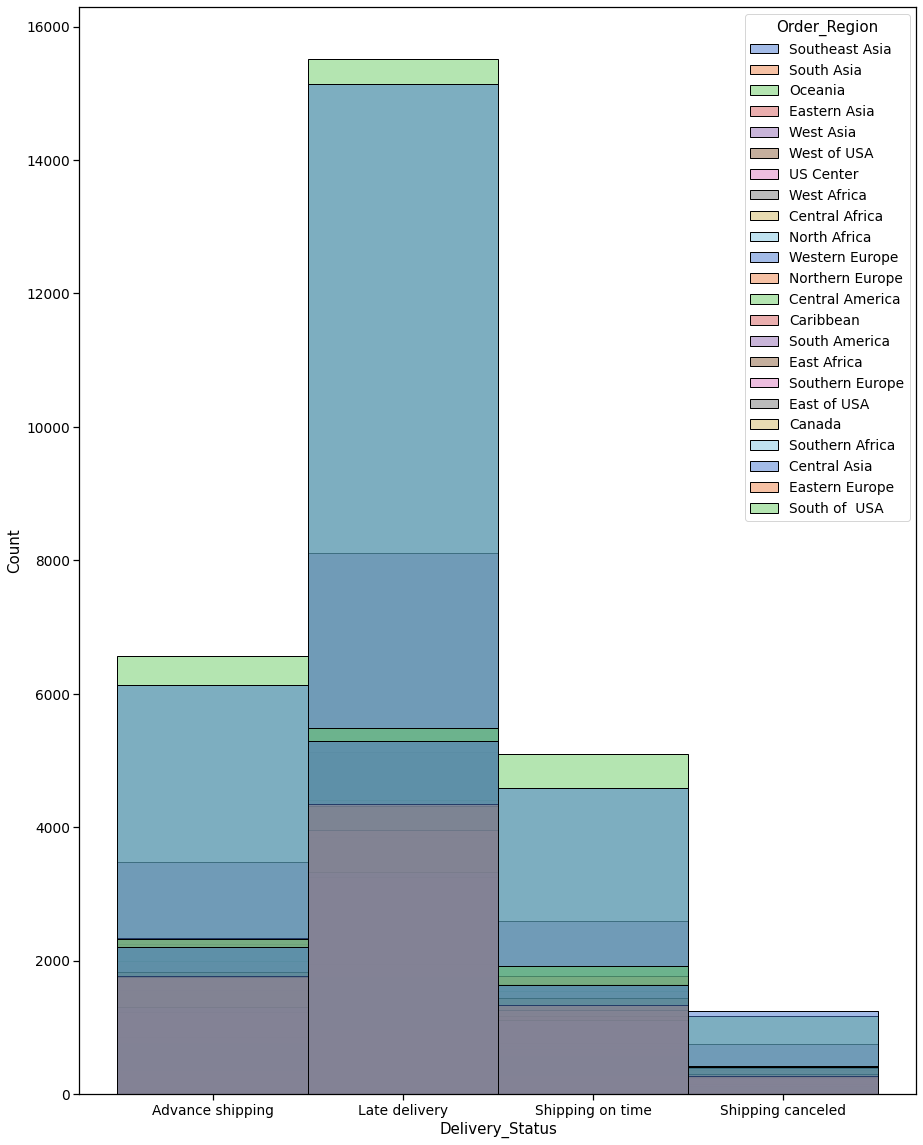

In [141]:
# Then with Order_Region
df_Region = df[['Delivery_Status' , 'Order_Region']]

#we can now create our histogram
plt.figure (figsize=(15,20))
sns.set_context("notebook", font_scale=1.25)
sns.histplot(data=df_Region, x='Delivery_Status', hue='Order_Region', binwidth=0.3 , palette='muted')

- From here we can see that the most frequent class in the delivery is the 'Late delivery' this till us that we've a huge problem that needs to be fixed. However, the regions are not so clear so I'll try to take Top 5 to see top regions when it comes to the delay. 

In [26]:
# checking the top five Regions in our dataset 
Region_Top = df_Region['Order_Region'].value_counts().nlargest(5) #we get the top 5 regions 
Region_Top

Central America    28341
Western Europe     27109
South America      14935
Oceania            10148
Northern Europe     9792
Name: Order_Region, dtype: int64

In [27]:
# creating df to visualize the top 5 regions 
largest_countries = ['Central America','Western Europe','South America', 'Oceania', 'Northern Europe']
Region_Top_df = df_Region[df_Region['Order_Region'].isin(largest_countries)]
Region_Top_df

,Delivery_Status,Order_Region
3,Advance shipping,Oceania
4,Advance shipping,Oceania
5,Shipping canceled,Oceania
22,Late delivery,Oceania
23,Shipping canceled,Oceania
...,...,...
180502,Advance shipping,Oceania
180503,Advance shipping,Oceania
180504,Advance shipping,Oceania
180516,Late delivery,Oceania


<AxesSubplot:xlabel='Delivery_Status', ylabel='Count'>

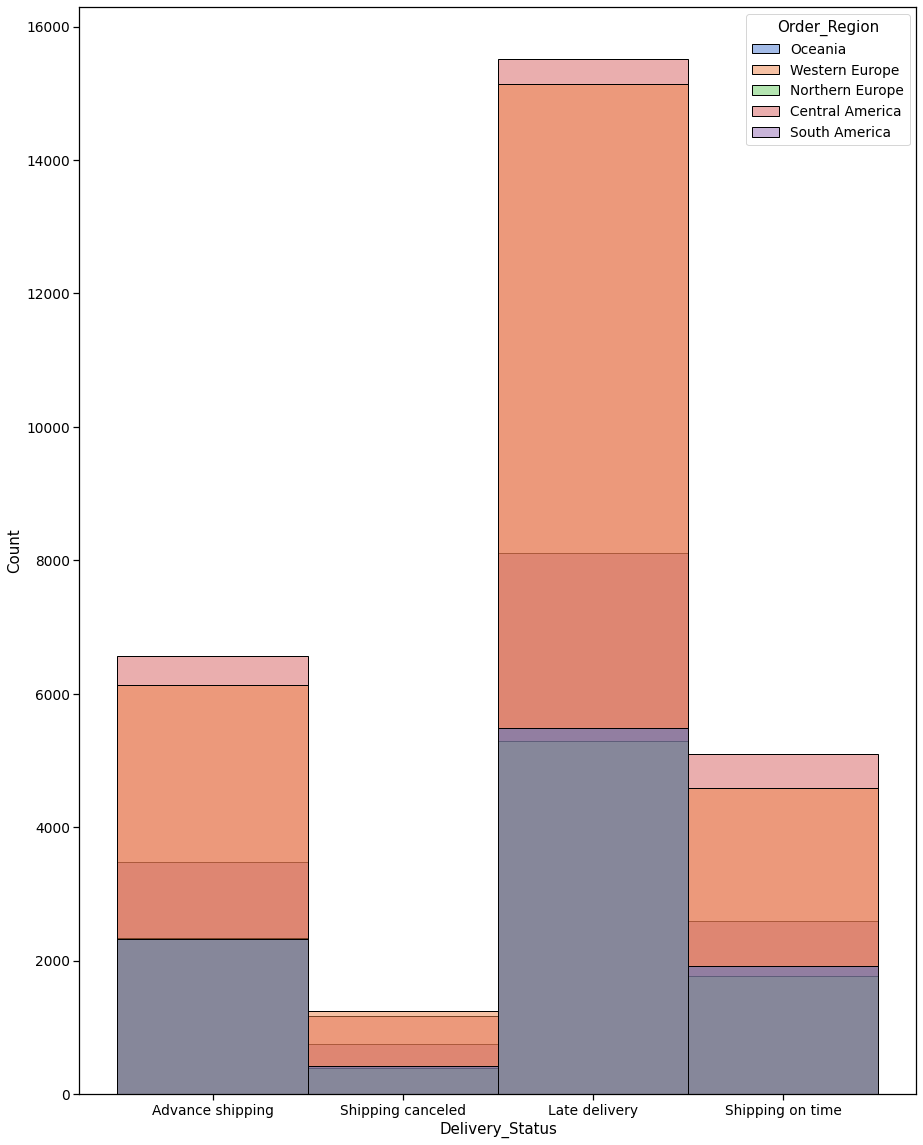

In [28]:
#we can now create our histogram
plt.figure (figsize=(15,20))
sns.set_context("notebook", font_scale=1.25)
sns.histplot(data=Region_Top_df, x='Delivery_Status', hue='Order_Region', binwidth=0.3 , palette='muted')

- Now things are more clear, we can see that Central America has the highest values in all categories and then Western Europe.

<AxesSubplot:xlabel='Delivery_Status', ylabel='Count'>

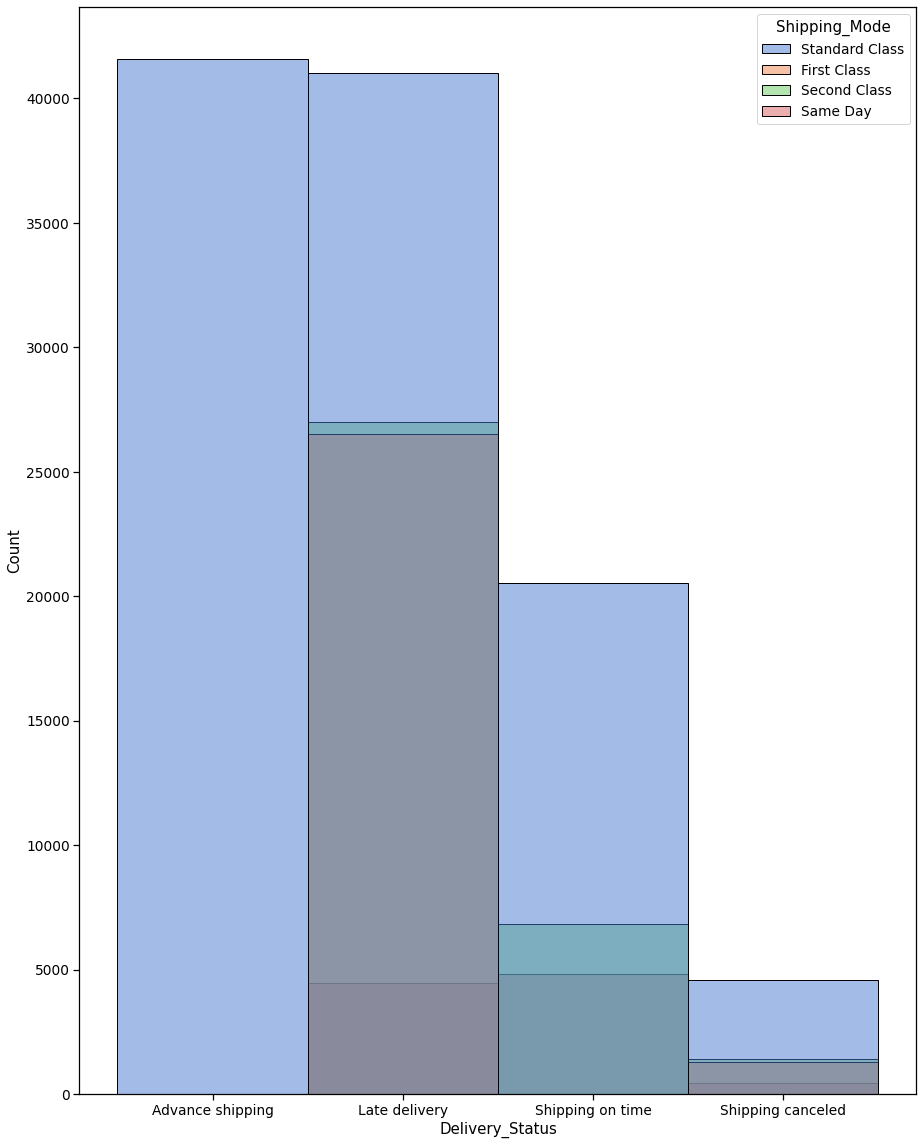

In [216]:
df_ship_mode = df[['Delivery_Status','Shipping_Mode']]

#we can now create our histogram
plt.figure (figsize=(15,20))
sns.set_context("notebook", font_scale=1.25)
sns.histplot(data=df_ship_mode, x='Delivery_Status', hue='Shipping_Mode', binwidth=0.3 , palette='muted')

### Understanding Numerical Columns , 


### 1- Pairplot

In [218]:
df_shipping = df[['Days_for_shipment','Days_for_shipping' , 'Delivery_Status']]

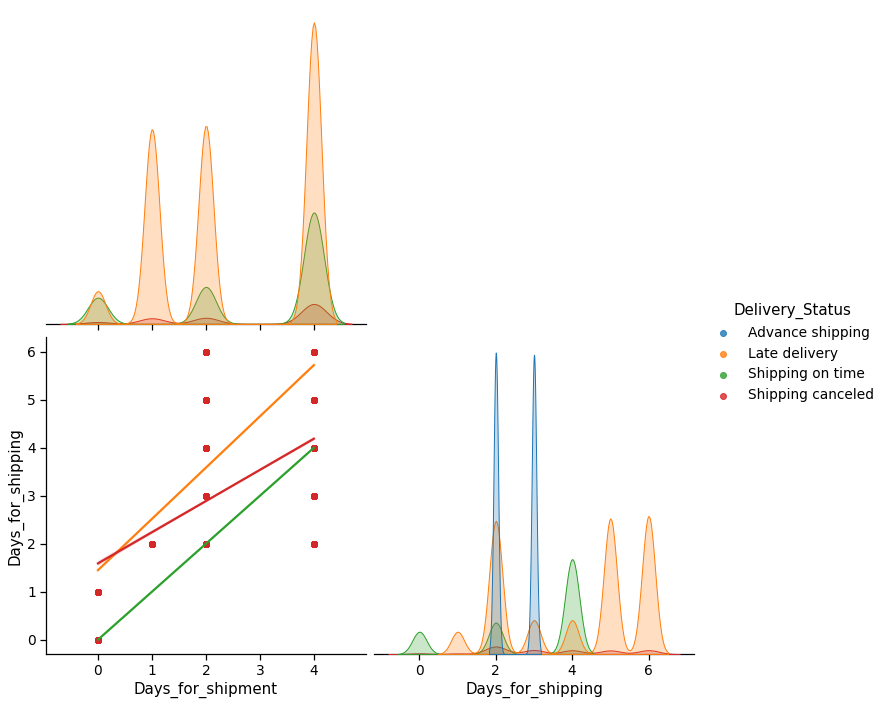

In [219]:
#corner=True would produce charts only once
sns.pairplot(df_shipping, kind='reg', hue='Delivery_Status', corner=True, size=5)

- There are linear positive correlation between the days of Shipment and days of shipping and that is because normally the shipping takes more days than the scheduled ones in 'Late Delivery' and 'Shipping canceled' categories. We can see also in the thid category 'Shipping on time' has the most match with the points since is it took the same scheduled days.

## Data Wrangling 

we can split the "Shipping_date" and "Order_date" columns to make them easier to analyze.

#### NOTE: 
I tried chaning the type with spark but there were two problems either it create new df with empty values or creat new df with only changed column. 

In [144]:
from pyspark.sql.functions import col
from pyspark.sql.types import DateType , TimestampType

In [196]:
df2 = data.withColumn("Shipping_date", 
                                  data["Shipping_date"]
                                  .cast('timestamp'))
df2.printSchema()

In [197]:
data2.select('Shipping_date').show(2)

+-------------+
|Shipping_date|
+-------------+
|         null|
|         null|
+-------------+
only showing top 2 rows



In [157]:
data_final = data.select(col("Shipping_date").cast('timestamp'))

In [158]:
data_final.printSchema()

root
 |-- Shipping_date: timestamp (nullable = true)



In [173]:
# date column to year and month columns
data2 = data.withColumn('Shipping_Year', F.year(F.col('Shipping_date')))
data2 = data.withColumn('Shipping_Month', F.month(F.col('Shipping_date')))

data.drop('Shipping_date') #we don't need posting_date anymore

# ----------------------------------------------------------------------------------------------

# date column to year and month columns
data2 = data.withColumn('Order_Year', F.year(F.col('Order_date')))
data2 = data.withColumn('Order_Month', F.month(F.col('Order_date')))

data.drop('Order_date') #we don't need posting_date anymore

#### USING PANDAS 

In [11]:
df['Shipping_date'] = pd.to_datetime(df['Shipping_date'])
df['Order_date'] = pd.to_datetime(df['Order_date'])

In [12]:
df['Shipping_year'] = pd.DatetimeIndex(df['Shipping_date']).year
df['Shipping_month'] = pd.DatetimeIndex(df['Shipping_date']).month

# ---------------------------------------------------------------------

df['Order_year'] = pd.DatetimeIndex(df['Order_date']).year
df['Order_month'] = pd.DatetimeIndex(df['Order_date']).month

In [13]:
col = ['Shipping_date' , 'Order_date']
df.drop(columns = col , inplace =True)

In [14]:
df.describe()

,Days_for_shipping,Days_for_shipment,Category_Id,Customer_Id,Department_Id,Latitude,Longitude,Order_Id,Order_Item_Discount,Order_tem_Discount_Rate,...,Sales,Order_Item_Total,Order Profit Per Order,Product Card Id,Product_Price,Product_Status,Shipping_year,Shipping_month,Order_year,Order_month
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,...,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.0,180519.000000,180519.000000,180519.000000,180519.000000
mean,3.497654,2.931847,31.851451,6691.379495,5.443460,29.719955,-84.915675,36221.894903,20.664741,0.101668,...,203.772096,183.107609,21.974989,692.509764,141.232550,0.0,2015.979404,6.252494,2015.971150,6.235449
std,1.623722,1.374449,15.640064,4162.918106,1.629246,9.813646,21.433241,21045.379569,21.800901,0.070415,...,132.273077,120.043670,104.433526,336.446807,139.732492,0.0,0.831962,3.398391,0.829429,3.403571
min,0.000000,0.000000,2.000000,1.000000,2.000000,-33.937553,-158.025986,1.000000,0.000000,0.000000,...,9.990000,7.490000,-4274.979980,19.000000,9.990000,0.0,2015.000000,1.000000,2015.000000,1.000000
25%,2.000000,2.000000,18.000000,3258.500000,4.000000,18.265432,-98.446312,18057.000000,5.400000,0.040000,...,119.980003,104.379997,7.000000,403.000000,50.000000,0.0,2015.000000,3.000000,2015.000000,3.000000
50%,3.000000,4.000000,29.000000,6457.000000,5.000000,33.144863,-76.847908,36140.000000,14.000000,0.100000,...,199.919998,163.990005,31.520000,627.000000,59.990002,0.0,2016.000000,6.000000,2016.000000,6.000000
75%,5.000000,4.000000,45.000000,9779.000000,7.000000,39.279617,-66.370583,54144.000000,29.990000,0.160000,...,299.950012,247.399994,64.800003,1004.000000,199.990005,0.0,2017.000000,9.000000,2017.000000,9.000000
max,6.000000,4.000000,76.000000,20757.000000,12.000000,48.781933,115.263077,77204.000000,500.000000,0.250000,...,1999.989990,1939.989990,911.799988,1363.000000,1999.989990,0.0,2018.000000,12.000000,2018.000000,12.000000


- From here we can see that our dataset period is from 2015 - 2018 

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 41 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Type                     180519 non-null  object 
 1   Days_for_shipping        180519 non-null  int32  
 2   Days_for_shipment        180519 non-null  int32  
 3   Delivery_Status          180519 non-null  object 
 4   Late_delivery_risk       180519 non-null  int32  
 5   Category_Id              180519 non-null  int32  
 6   Category_Name            180519 non-null  object 
 7   Customer_City            180519 non-null  object 
 8   Customer_Country         180519 non-null  object 
 9   Customer_Id              180519 non-null  int32  
 10  Customer_Segment         180519 non-null  object 
 11  Customer_State           180519 non-null  object 
 12  Customer_Street          180519 non-null  object 
 13  Department_Id            180519 non-null  int32  
 14  Depa

## Data Conversion and Preparation For ML

In [52]:
# taking only needed columns for the modelling 
df2 = df[[ 'Delivery_Status' , 'Latitude' , 'Longitude' , 'Order_State' , 'Order_Region' , 'Order_City' , 'Order_Country' ,
          'Customer_City' , 'Customer_State' ,'Customer_Segment', 'Days_for_shipment' , 'Days_for_shipping', 'Shipping_Mode']]

In [16]:
df2[['Delivery_Status']] = df2[['Delivery_Status']].apply(lambda col:pd.Categorical(col).codes)
df2.Delivery_Status = df2.Delivery_Status.astype('int')

In [17]:
df2['Delivery_Status'].value_counts()

1    98977
0    41592
3    32196
2     7754
Name: Delivery_Status, dtype: int64

In [53]:
# converting the panads df to data Pyspark df
sparkdf = spark.createDataFrame(df2) 

In [54]:
sparkdf.show(2)

+----------------+-----------+------------+---------------+--------------+----------+-------------+-------------+--------------+----------------+-----------------+-----------------+--------------+
| Delivery_Status|   Latitude|   Longitude|    Order_State|  Order_Region|Order_City|Order_Country|Customer_City|Customer_State|Customer_Segment|Days_for_shipment|Days_for_shipping| Shipping_Mode|
+----------------+-----------+------------+---------------+--------------+----------+-------------+-------------+--------------+----------------+-----------------+-----------------+--------------+
|Advance shipping| 18.2514534|-66.03705597|Java Occidental|Southeast Asia|    Bekasi|    Indonesia|       Caguas|            PR|        Consumer|                4|                3|Standard Class|
|   Late delivery|18.27945137| -66.0370636|       Rajast�n|    South Asia|   Bikaner|        India|       Caguas|            PR|        Consumer|                4|                5|Standard Class|
+--------------

### Converting The Categorical  Columns 
Here I have used String Indexer to encode the string columns. By default, the labels are assigned according to the frequencies. So, the most frequent gets an index of 0.

In [55]:
from pyspark.ml.feature import StringIndexer

cat_cols = ['Order_State', 'Order_Region', 'Order_City', 'Order_Country', \
            'Customer_City', 'Customer_State', 'Customer_Segment', 'Shipping_Mode' , 'Delivery_Status'] 

for col in cat_cols:
    label_stringIdx = StringIndexer(inputCol = col, outputCol=col+'_idx')
    sparkdf = label_stringIdx.fit(sparkdf).transform(sparkdf)

    
sparkdf = sparkdf.drop(*cat_cols)    
sparkdf.show(2)

+-----------+------------+-----------------+-----------------+---------------+----------------+--------------+-----------------+-----------------+------------------+--------------------+-----------------+-------------------+
|   Latitude|   Longitude|Days_for_shipment|Days_for_shipping|Order_State_idx|Order_Region_idx|Order_City_idx|Order_Country_idx|Customer_City_idx|Customer_State_idx|Customer_Segment_idx|Shipping_Mode_idx|Delivery_Status_idx|
+-----------+------------+-----------------+-----------------+---------------+----------------+--------------+-----------------+-----------------+------------------+--------------------+-----------------+-------------------+
| 18.2514534|-66.03705597|                4|                3|           45.0|             5.0|         167.0|             10.0|              0.0|               0.0|                 0.0|              0.0|                1.0|
|18.27945137| -66.0370636|                4|                5|          136.0|             9.0|     

In [31]:
sparkdf.printSchema()

root
 |-- Delivery_Status: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Days_for_shipment: long (nullable = true)
 |-- Days_for_shipping: long (nullable = true)
 |-- Order_State_idx: double (nullable = false)
 |-- Order_Region_idx: double (nullable = false)
 |-- Order_City_idx: double (nullable = false)
 |-- Order_Country_idx: double (nullable = false)
 |-- Customer_City_idx: double (nullable = false)
 |-- Customer_State_idx: double (nullable = false)
 |-- Customer_Segment_idx: double (nullable = false)
 |-- Shipping_Mode_idx: double (nullable = false)



### Combining Feature Columns

Lastly, I have used Vector Assembler to combine all of the features into a single vector column. Here the new single vector column is called 'features'.

In [56]:
from pyspark.ml.feature import VectorAssembler

#remove Delivery_Status -> we need this to be our label
cols = sparkdf.columns
cols.remove('Delivery_Status_idx')

#vector assembler will take all the columns and convert them into one column called features
assembler = VectorAssembler(inputCols=cols, outputCol="features")

#the .transform will apply the changes here
sparkdf = assembler.transform(sparkdf)

In [57]:
sparkdf.show(5)

+-----------+------------+-----------------+-----------------+---------------+----------------+--------------+-----------------+-----------------+------------------+--------------------+-----------------+-------------------+--------------------+
|   Latitude|   Longitude|Days_for_shipment|Days_for_shipping|Order_State_idx|Order_Region_idx|Order_City_idx|Order_Country_idx|Customer_City_idx|Customer_State_idx|Customer_Segment_idx|Shipping_Mode_idx|Delivery_Status_idx|            features|
+-----------+------------+-----------------+-----------------+---------------+----------------+--------------+-----------------+-----------------+------------------+--------------------+-----------------+-------------------+--------------------+
| 18.2514534|-66.03705597|                4|                3|           45.0|             5.0|         167.0|             10.0|              0.0|               0.0|                 0.0|              0.0|                1.0|[18.2514534,-66.0...|
|18.27945137| -6

### Set columns and Split

Before modelling, the data are split into train and test data sets. We will make the train set bigger at this point as will incorporate cross validation later on.

In [58]:
train, test = sparkdf.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 144405
Test Dataset Count: 36114


In [ ]:
train.show(5)

In [ ]:
test.show(5)

## Model Building


- Here featuresCol is the list of features of the Data Frame, here in our case it is the features column. labelCol is the targeted feature which is Delivery_Status.


- Note: The default value of maxBins is (=32). however, it should be greater or equal to the maximum number of categories for categorical features. Mine is 3597 so I assigned 3600 to it. 

- rfModel.transform(test) transforms the test dataset. This will add new columns to the Data Frame such as prediction, rawPrediction, and probability.


In [59]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Delivery_Status_idx' , maxBins=3600)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [63]:
predictions.select("Delivery_Status_idx", "prediction").show(10)

+-------------------+----------+
|Delivery_Status_idx|prediction|
+-------------------+----------+
|                1.0|       1.0|
|                0.0|       0.0|
|                1.0|       1.0|
|                0.0|       0.0|
|                0.0|       0.0|
|                1.0|       1.0|
|                3.0|       1.0|
|                0.0|       0.0|
|                3.0|       2.0|
|                3.0|       2.0|
+-------------------+----------+
only showing top 10 rows



### Evaluation


Now we have applied the classifier for our testing data and we got the predictions. Then we need to evaluate our model.

In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Delivery_Status_idx", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.9144030229410472
Test Error = 0.08559697705895275
